## Exploring Data Scraped From wine.com

In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from ipywidgets import widgets, interact

wine = pd.read_csv('wdc_cleaned.csv')

In [12]:
print(f'Overall shape of the review database: {wine.shape}')

Overall shape of the review database: (10247, 13)


### How many wines and vintages?

In [13]:
wine_names = set(wine['name'].values)
print(f'{len(wine_names)} different wines')
vintages = set(wine['vintage'].values) - {0}  # we encode non vintage as 0
print(f'{len(vintages)} vintages from {min(vintages)} to {max(vintages)}')
w_v_pairs = set(wine['nameyear'].values)
print(f'{len(w_v_pairs)} different wine/vintage pairs')
# there are 5,089 SKUs on the site that I scraped, but I only took those with pro reviews
print(f'{len(w_v_pairs)/5089:.0%} of the wines on the site had pro reviews')
print('Average rating is {0:.2f}'.format(wine['rating'].mean()))

# We want average price of the wines but not weighted by number of reviews
wine_uniq = wine.sort_values(by='nameyear')
wine_uniq['duplicate'] = (wine_uniq['nameyear'] == wine_uniq['nameyear'].shift())
# duplicates happen because the same wine has multiple ratings
wine_uniq = wine_uniq[~wine_uniq['duplicate']]
print('Average price is ${0:.2f}'.format(wine_uniq['price_per_750'].median()))


2743 different wines
31 vintages from 1969 to 2019
3459 different wine/vintage pairs
68% of the wines on the site had pro reviews
Average rating is 94.10
Average price is $89.99


### What do we have for Origin?

In [14]:
# How many pairs of country/subregion do we have?
pairs = []
for idx in wine.index:
    # null values means vector operations don't return the results we need
    if type(wine.loc[idx, 'subregion'])==float:
        pairs.append(wine.loc[idx, 'country'])
    else:
        pairs.append(wine.loc[idx, 'country'] + ', ' + wine.loc[idx, 'subregion'])
pairs_dict = {s: pairs.count(s) for s in set(pairs)}
pairs_dict = {k: v for k, v in sorted(pairs_dict.items(), key=lambda item: item[1], reverse=True)}
print(f'{len(pairs_dict)} pairs of Country/Region')
# seems manageable

90 pairs of Country/Region


### What does the price data look like?

In [15]:
# Let's check the prices
cheap_px = min(wine["price_per_750"].values)
cheap_nm = wine[wine['price_per_750']==cheap_px]['nameyear'].iloc[0]
print(f'Cheapest wine is {cheap_nm} at ${cheap_px:.2f} per bottle')

high_px = max(wine["price_per_750"].values)
high_nm = wine[wine['price_per_750']==high_px]['nameyear'].iloc[0]
print(f'Most expensive wine is {high_nm} at ${high_px:,.2f} per bottle')

Cheapest wine is Dominio de Eguren Protocolo Tinto 2017 at $8.99 per bottle
Most expensive wine is Chateau Petrus 2015 at $4,999.98 per bottle


### How do the raters look?

Index(['Robert Parker', 'James Suckling', 'Wine Spectator', 'Wine Enthusiast',
       'Jeb Dunnuck', 'Decanter', 'Vinous', 'Wine & Spirits', 'wine.com',
       'Burghound.com', 'Tim Atkin', 'Tasting Panel', 'Conn Guide', 'IWC'],
      dtype='object', name='rater')


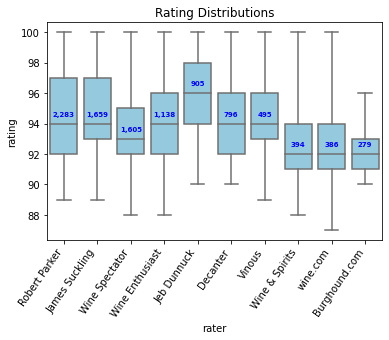

In [16]:
group_df = wine.groupby('rater').agg({'name': 'count', 'rating': 'min'})\
                .sort_values(by='name', ascending = False)\
                .rename({'name': 'count', 'rating':'min_rating'}, axis='columns')
print(group_df.index)
# Let's get rid of everybody below Burghound.  (I want to keep him because he's great for Burgundy)
keepers = group_df.index[:-4]
wine = wine[wine['rater'].isin(keepers)]
n_rats = [f'{s:,.0f}' for s in group_df['count'].to_list()[:-4]]

# Find the order
order_idx = wine.groupby('rater').count().sort_values(by='name', ascending=False).index.to_list()
ax1 = sns.boxplot(x='rater', y='rating', data=wine, order=order_idx, color='skyblue', whis=100)
# whis=100 disables outlier categorisation in seaborn
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=55, horizontalalignment='right')
ax1.set_title("Rating Distributions")

# Put counts inside the boxes
pos = range(len(n_rats))
medians = [wine[wine['rater']==s]['rating'].median() for s in order_idx]

for tick,label in zip(pos,ax1.get_xticklabels()):
    ax1.text(pos[tick], medians[tick] + .5, n_rats[tick],
    horizontalalignment='center', size='x-small', color='b', weight='semibold')

plt.show()

# wine.com probably doesn't try to sell very low rated wines.

### Comparing Price vs. Rating

In [17]:
# First, let's remove outliers.  I'm not interested in wine for > $500
# Then let's nomalize the ratings
wine = wine[wine['price_per_750']<=500]
wine['rating'] = wine['rating'] - wine['rating'].mean()

# 'subregion' has strings and NaNs.  I want to find unique subregions OTHER than NaNs
def subregion_list(ctry):
    temp_s = wine[wine['country']==ctry]['subregion']
    temp_s = temp_s[~temp_s.isnull()]
    return temp_s.unique().tolist()

def plot_px_vs_rating(ctry, subr):
    if ctry == 'All':
        wine_sub = wine
    else:
        if subr == 'All':
            wine_sub = wine[wine['country']==ctry]
        else:
            wine_sub = wine[(wine['country']==ctry) & (wine['subregion']==subr)]
    ax2 = px.scatter(wine_sub, x='price_per_750', y='rating', color = 'rater', hover_data = ['nameyear'], trendline="ols")
   # ax2.update_layout(xaxis_type="log") - not required since we have the $500 cutoff
    ax2.show()

    
ctry_list =['All'] + wine['country'].sort_values().unique().tolist()
reg_list = ['All']

ctr_widg = widgets.Dropdown(options=ctry_list, value='All', description='Country',
    disabled=False)
reg_widg = widgets.Dropdown(options=reg_list, value='All', description='Sub-Region',
    disabled=False)

def update_subr(ctry):
    if ctry['new'] == 'All':
        reg_widg.options = ['All']
    else:
        reg_widg.options = ['All'] + subregion_list(ctry['new'])

        
ctr_widg.observe(update_subr, 'value')
interact(plot_px_vs_rating, ctry=ctr_widg, subr=reg_widg)

interactive(children=(Dropdown(description='Country', options=('All', 'Argentina', 'Australia', 'Austria', 'Ch…

<function __main__.plot_px_vs_rating(ctry, subr)>

### Comparing Vintage vs. Rating

In [18]:
# what about rating vs vintage?  Let's focus on the years where we really have data
vint_wine = wine[wine['vintage']>=1995]

rating_freq = vint_wine[['name', 'vintage', 'rating']]\
                        .groupby(['vintage', 'rating']).count()\
                        .rename({'name': 'count'}, axis='columns')

ax3 = px.scatter(rating_freq, x = rating_freq.index.get_level_values(0),
                  y = rating_freq.index.get_level_values(1), size='count')



#fig1 = px.scatter(vint_wine, x='vintage', y='rating', color = 'rater', hover_data = ['nameyear'])
ax3.update_layout(title="All Ratings")
ax3.show()

# try vintage/rating/count grouped by rater and sorted
rated_wine = vint_wine[['name', 'vintage', 'rater', 'rating']]\
                        .groupby(['vintage', 'rater']).agg({'name': 'count', 'rating': 'mean'})\
                        .rename({'name': 'count'}, axis='columns')

ax4 = px.scatter(rated_wine, x = rated_wine.index.get_level_values(0), y='rating', 
                  color=rated_wine.index.get_level_values(1), size='count')
ax4.update_layout(
    title="Average Ratings",
    xaxis_title="vintage")
ax4.show()

# This means we'll be over-weighting recent vintages if we just do a regression
# on the data. We could sample to reduce bias in the data. I expect prices cluster too.
# We may not have enough of a spread of raters for the older ones though.

In [19]:
# First let's do a price vs. rating linear regression across all wines
X = wine['rating'].to_numpy()
Y = wine['price_per_750'].to_numpy()
beta_0 = Y.mean()
Y = Y - beta_0
beta = X.T @ Y / (X.T @ X)
reg_line_y = np.linspace(-5.5, 2.5, 100)
reg_line_x = beta_0 + beta * reg_line_y

# Now let's group by region and plot the graph
reg_wine = wine.groupby(['country', 'subregion']).agg({'price_per_750': 'mean', 'rating': 'mean', 'name': 'count'})
reg_wine.columns = reg_wine.columns.str.replace('name', 'count')
fig = px.scatter(reg_wine, x = 'price_per_750', y='rating',hover_data=[reg_wine.index.get_level_values(1)],
                 color=reg_wine.index.get_level_values(0), size='count', size_max=60)
fig.add_scatter(x = reg_line_x, y= reg_line_y, name='Regression')
fig.update_layout(
    title='Rating vs Price by Region',
    xaxis_title='price for 750ml')
fig.show()